# No joke

In [1]:
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout, SimpleRNN
from keras.optimizers import RMSprop

Using TensorFlow backend.


## Settings

In [2]:
MAX_LEN = 50
MAX_WORDS = 10000
EMBEDDING_DIM = 100

## Get the data

In [3]:
joke_sentences = []

with open("joke_sentences.txt", "r") as csv_file:
    for row in csv_file:
        joke_sentences.append(row)

In [4]:
len(joke_sentences)

19860

In [5]:
joke_sentences[0]

'Der Lehrer fragt Fritzchen: „Wenn du 5€ vor dir liegen hast, und ich dir 2€ davon wegnehme, was gibt das dann?“ Fritzchen: „Prügel!“ \n'

In [6]:
no_joke_sentences = []

with open("no_joke_sentences.txt", "r") as csv_file:
    for row in csv_file:
        no_joke_sentences.append(row)

In [7]:
len(no_joke_sentences)

999926

In [8]:
no_joke_sentences[1]

'2\t000 Besucher werden pro Jahr im Klimahaus erwartet.\n'

## Prepare the data

In [9]:
def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

replacing_dict = {
    "„": "",
    "“": "",
    "\n": "",
}

In [10]:
joke_sentences = [
    replace_all(joke_sentence, replacing_dict)
    for joke_sentence in joke_sentences
]

In [11]:
joke_sentences[0]

'Der Lehrer fragt Fritzchen: Wenn du 5€ vor dir liegen hast, und ich dir 2€ davon wegnehme, was gibt das dann? Fritzchen: Prügel! '

In [12]:
no_joke_sentences = [
    replace_all(no_joke, replacing_dict)[no_joke.index("\t")+1:]
    for no_joke in no_joke_sentences
]

In [13]:
no_joke_sentences[0]

'000 Arbeitsplätze werden weltweit gestrichen.'

In [14]:
# Balance data sets
np.random.shuffle(no_joke_sentences)
no_joke_sentences = no_joke_sentences[:len(joke_sentences)]

In [15]:
no_joke_sentences[0]

'Ein ganzes Dorf ist auf den Beinen.'

In [16]:
sentences = []
labels = []

for joke in joke_sentences:
    sentences.append(joke)
    labels.append(1)
    
for no_joke in no_joke_sentences: 
    sentences.append(no_joke)
    labels.append(0)

In [17]:
print(f"Number of samples: {len(sentences)}")

Number of samples: 39720


In [18]:
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(sentences)

sequences = tokenizer.texts_to_sequences(sentences)
word_index = tokenizer.word_index

In [19]:
# Save tokenizer
with open('/home/martin/PycharmProjects/no_joke/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
tokenized_sentences = pad_sequences(sequences, maxlen=MAX_LEN)
labels = np.array(labels)

In [21]:
# Shuffle the data
indices = np.arange(tokenized_sentences.shape[0])
np.random.shuffle(indices)

tokenized_sentences = tokenized_sentences[indices]
labels = labels[indices]

## Train the model

### Neural Network

In [22]:
model = Sequential()
model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3)) # adding regularization

model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                320064    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,320,129
Trainable params: 1,320,129
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics = ['acc'])
history = model.fit(tokenized_sentences, labels, epochs=20, batch_size=32, validation_split=0.1)

/home/martin/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 35748 samples, validate on 3972 samples
Epoch 1/20
35748/35748 [==============================] - 17s 479us/step - loss: 0.4037 - acc: 0.8283 - val_loss: 0.2613 - val_acc: 0.9011
Epoch 2/20
35748/35748 [==============================] - 16s 452us/step - loss: 0.2078 - acc: 0.9197 - val_loss: 0.1636 - val_acc: 0.9406
Epoch 3/20
35748/35748 [==============================] - 16s 451us/step - loss: 0.1531 - acc: 0.9421 - val_loss: 0.1425 - val_acc: 0.9496
Epoch 4/20
35748/35748 [==============================] - 16s 454us/step - loss: 0.1309 - acc: 0.9513 - val_loss: 0.1276 - val_acc: 0.9527
Epoch 5/20
35748/35748 [==============================] - 16s 452us/step - loss: 0.1198 - acc: 0.9554 - val_loss: 0.1204 - val_acc: 0.9567
Epoch 6/20
35748/35748 [==============================] - 16s 457us/step - loss: 0.1119 - acc: 0.9593 - val_loss: 0.1162 - val_acc: 0.9605
Epoch 7/20
35748/35748 [==============================] - 16s 456us/step - loss: 0.1054 - acc: 0.9616 - val_loss: 0.1

In [24]:
def plot_results(history):
    accuracy = history.history['acc']
    validation_accuracy = history.history['val_acc']
    loss = history.history['loss']
    validation_loss = history.history['val_loss']
      
    epochs = range(1, len(accuracy)+1)
    
    plt.plot(epochs, accuracy, label='Training accuracy')
    plt.plot(epochs, validation_accuracy, label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend()
    
    plt.show()
    
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, validation_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    
    plt.show()

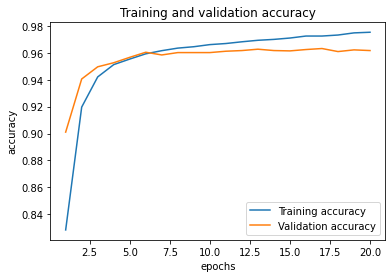

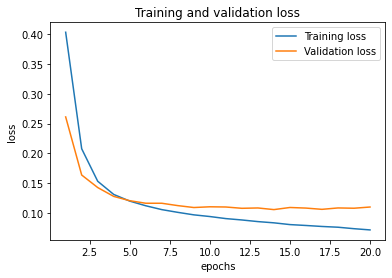

In [25]:
plot_results(history)

### RNN

In [26]:
rnn_model = Sequential()
rnn_model.add(Embedding(MAX_WORDS, 32))
rnn_model.add(SimpleRNN(64, dropout=0.1))
rnn_model.add(Dense(1, activation='sigmoid'))
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                6208      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 326,273
Trainable params: 326,273
Non-trainable params: 0
_________________________________________________________________


In [27]:
rnn_model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])
history = rnn_model.fit(tokenized_sentences, labels, epochs=20, batch_size=32, validation_split=0.1)

Train on 35748 samples, validate on 3972 samples
Epoch 1/20
35748/35748 [==============================] - 18s 505us/step - loss: 0.4114 - acc: 0.8254 - val_loss: 0.3121 - val_acc: 0.8852
Epoch 2/20
35748/35748 [==============================] - 17s 473us/step - loss: 0.2346 - acc: 0.8977 - val_loss: 0.1946 - val_acc: 0.9091
Epoch 3/20
35748/35748 [==============================] - 18s 495us/step - loss: 0.1808 - acc: 0.9208 - val_loss: 0.1605 - val_acc: 0.9471
Epoch 4/20
35748/35748 [==============================] - 18s 494us/step - loss: 0.1552 - acc: 0.9392 - val_loss: 0.1458 - val_acc: 0.9484
Epoch 5/20
35748/35748 [==============================] - 17s 481us/step - loss: 0.1401 - acc: 0.9475 - val_loss: 0.1348 - val_acc: 0.9524
Epoch 6/20
35748/35748 [==============================] - 17s 478us/step - loss: 0.1282 - acc: 0.9524 - val_loss: 0.1276 - val_acc: 0.9567
Epoch 7/20
35748/35748 [==============================] - 17s 477us/step - loss: 0.1210 - acc: 0.9557 - val_loss: 0.1

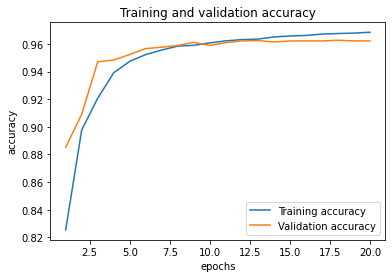

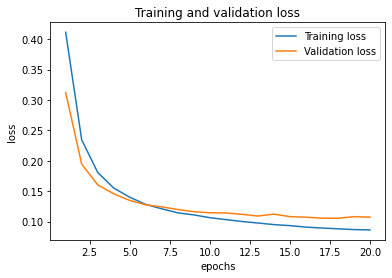

In [28]:
plot_results(history)

## Make predictions

In [29]:
def predict(model, text):
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_LEN)
    score = model.predict([x_test])[0]
    return score

In [30]:
predict(model, "Blondine")

array([0.9956442], dtype=float32)

In [31]:
predict(model, "Heute ist leider schlechtes Wetter.")

array([0.0499665], dtype=float32)

In [32]:
predict(rnn_model, "Blondine")

array([0.97030556], dtype=float32)

In [33]:
predict(rnn_model, "Heute ist leider schlechtes Wetter.")

array([0.0773247], dtype=float32)

## Save the model

In [34]:
model.save("/home/martin/PycharmProjects/no_joke/model.h5")

In [35]:
rnn_model.save("/home/martin/PycharmProjects/no_joke/rnnmodel.h5")